## two-moons 데이터를 사용해서 k-평균, 병합군집, DBSCAN알고리즘을 비교하시오.

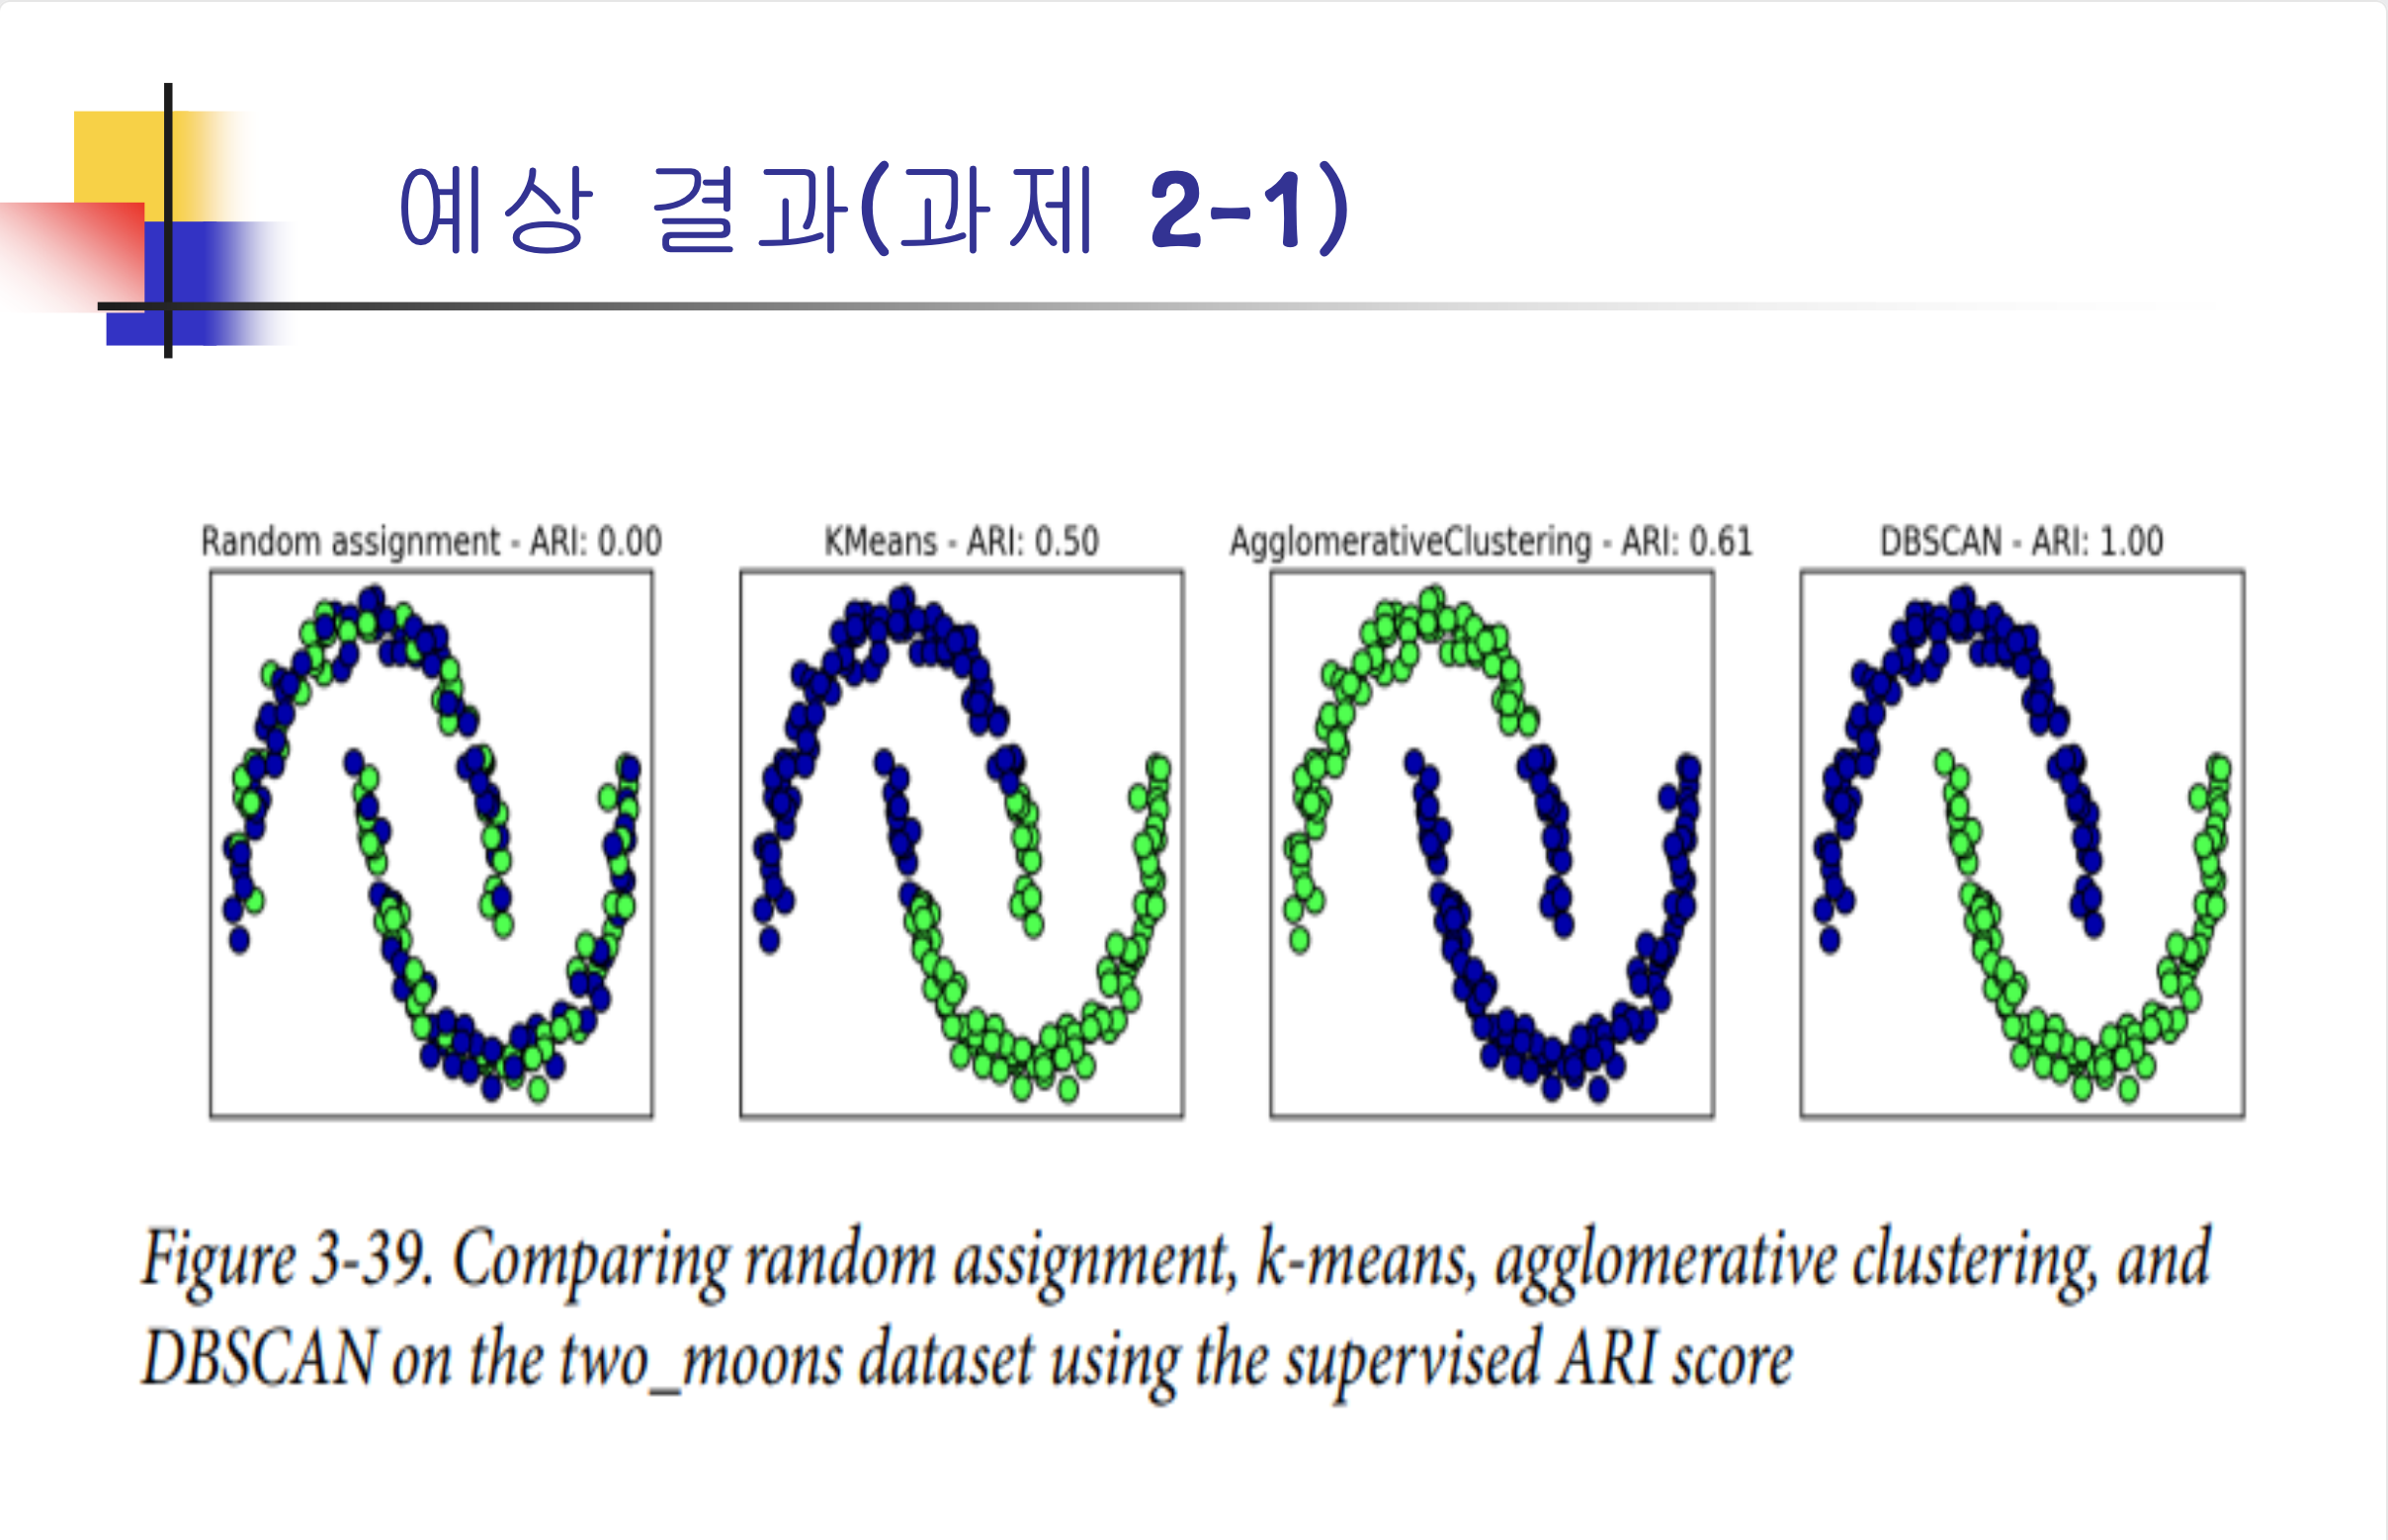

sklearn.feature_extraction 모듈에서 데이터 매트릭스의 형태(n_samples, n_features)를 뽑을 수 있다.



In [1]:
# 관련된 모듈 모두 호출

import time
import warnings

warnings.filterwarnings(action='ignore')

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice


from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics 

np.random.seed(0)

In [2]:
# Two_moons 데이터셋 불러오기(샘플의 수는 500) 

n_samples = 500
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)

In [3]:
# 불러온 데이터 분할 및 변환하기 

random_state = 170

X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

In [4]:
# 생성된 모델의 파라미터 디폴트 값 미리 지정하기

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

In [5]:
# 데이터셋의 파라미터 설정하기

datasets = [    
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    )
]

In [8]:
# 시각화 배경 생성하기

plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

<Figure size 1512x936 with 0 Axes>

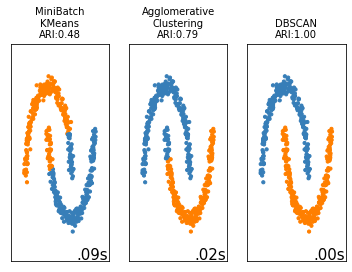

In [9]:
# 시각화하여 표현하기

plot_num = 1
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # 데이터셋의 특정 값에 따라 파라미터 수정하기
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # 파라미터 지정을 위한 데이터 표준화
    X = StandardScaler().fit_transform(X)
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity 행렬 생성
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # connectivity 행렬 대칭화하기
    connectivity = 0.5 * (connectivity + connectivity.T)

    # 클러스터링 객체 생성하기
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    
    dbscan = cluster.DBSCAN(eps=params["eps"])
    
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan)
    )


    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # kneighbors_graph의 warninig 캐치하기
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()

        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name+"\n"+f"ARI:{adjusted_rand_score(y, y_pred):.2f}", size=10)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # 이상치에 해당하는 검정값 추가
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

## Two-moons 데이터에서 실루엣 점수를 사용하여 k-평균, 병합 군집, DBSCAN 알고리즘의 결과를 비교하시오.

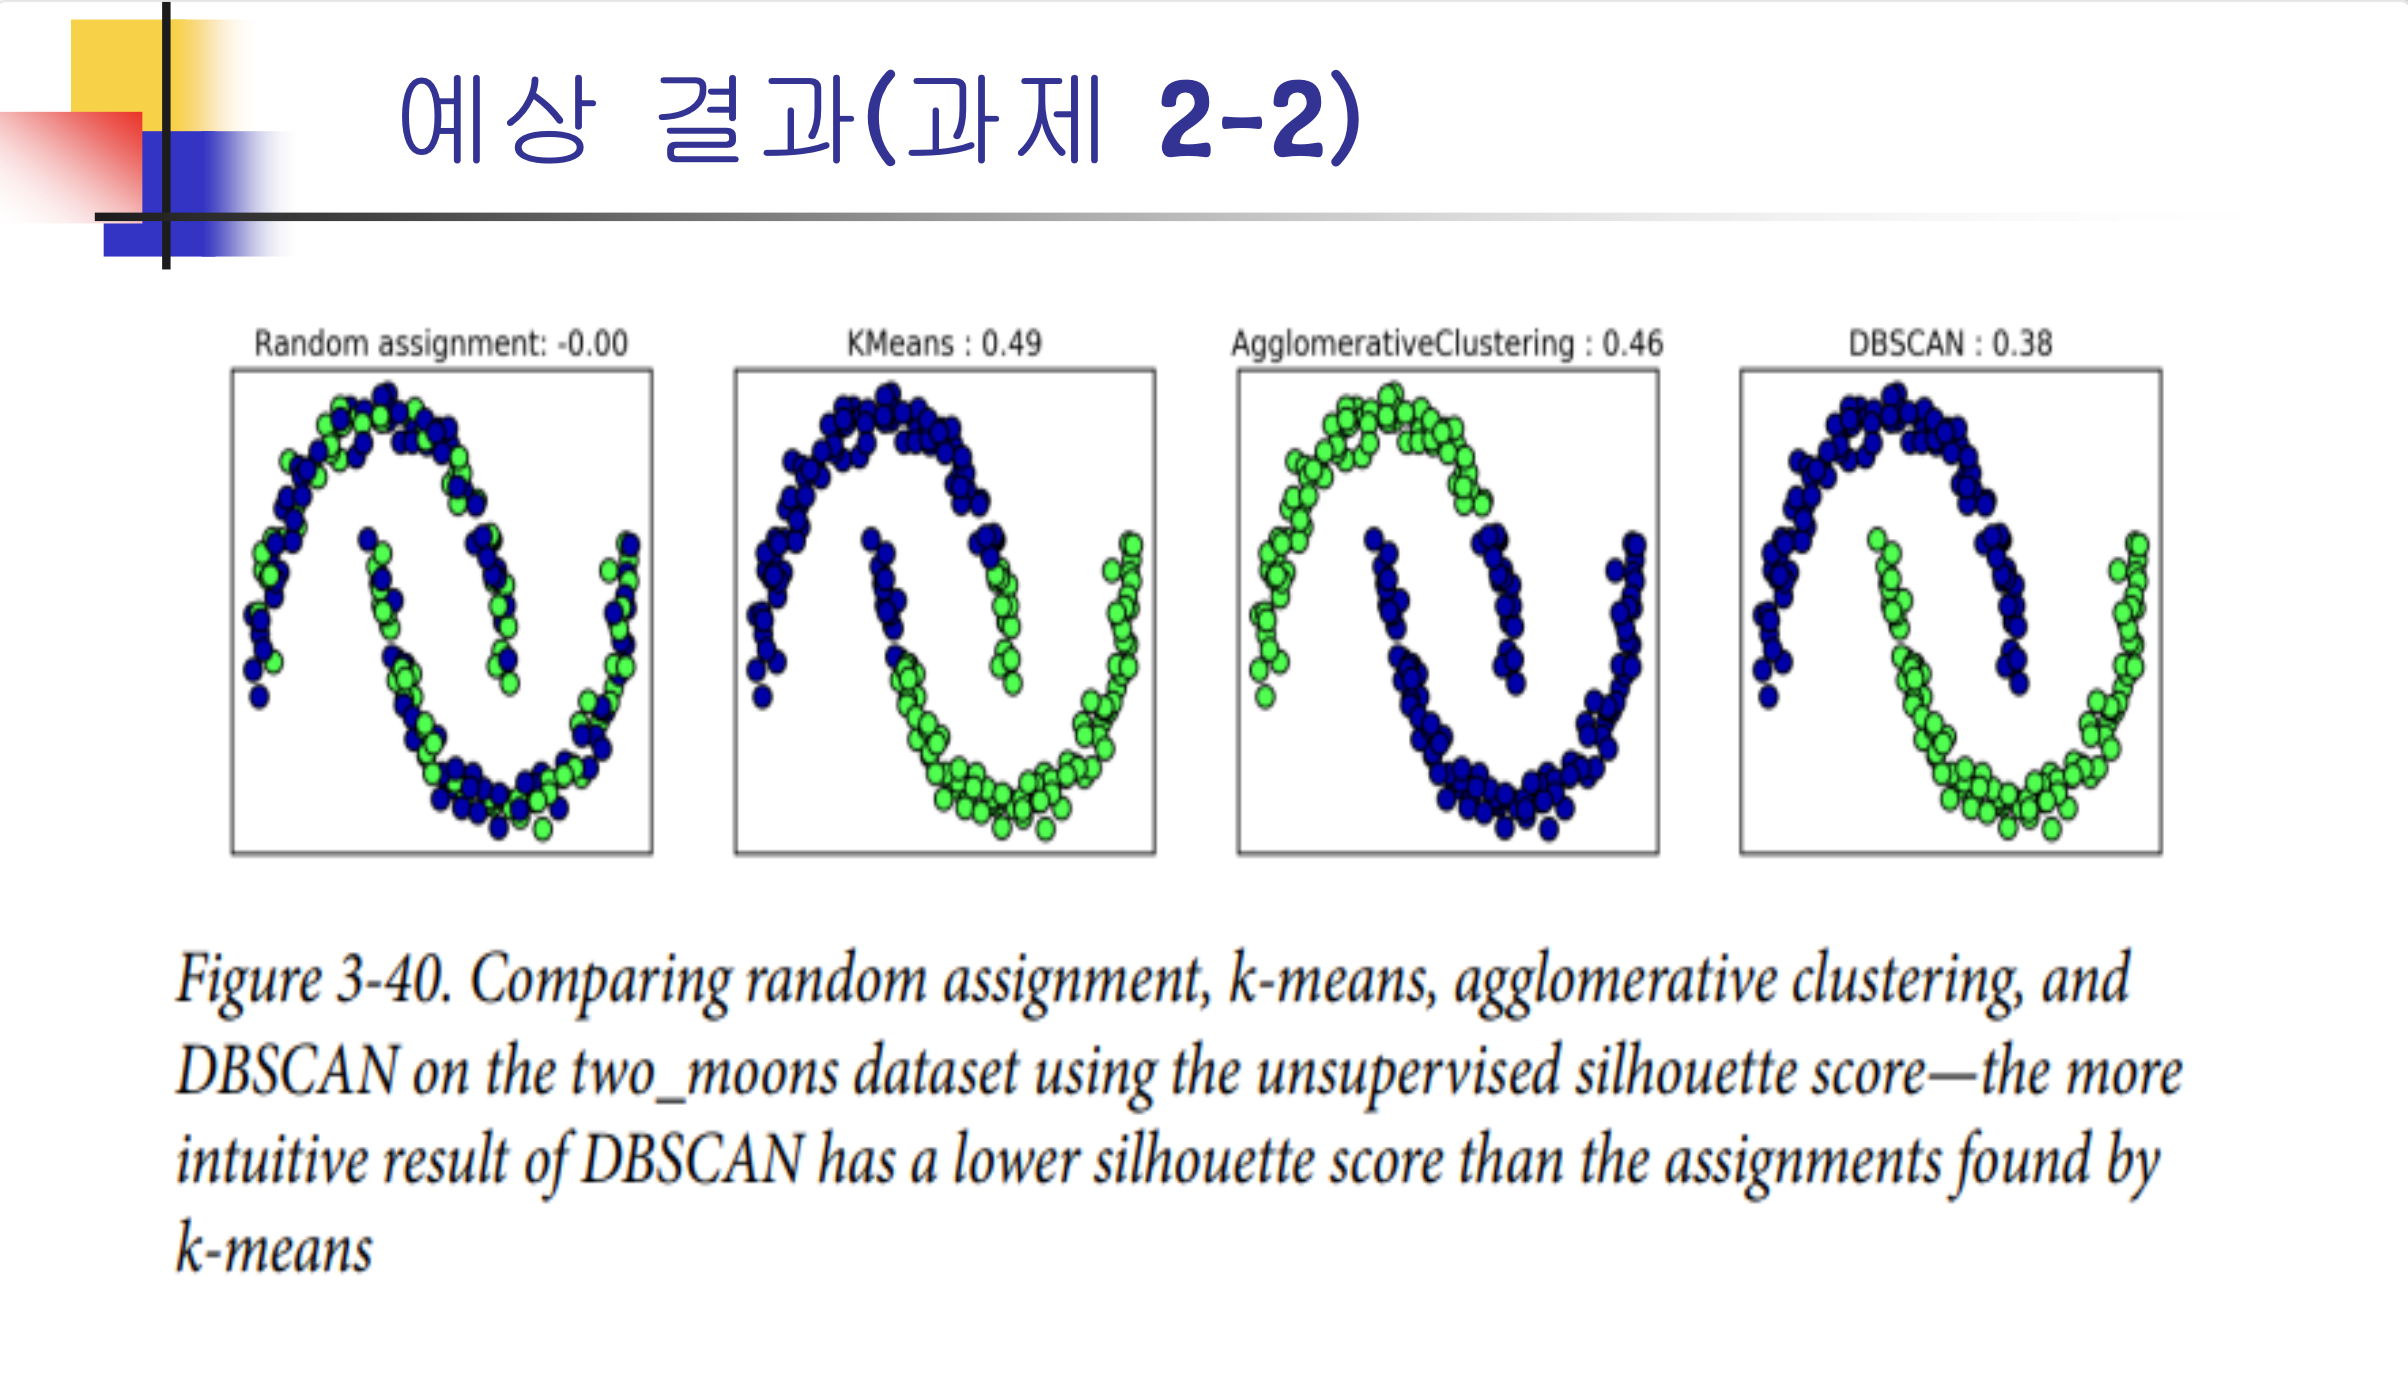

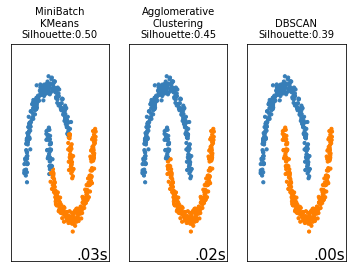

In [10]:
plot_num = 1
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # 데이터셋의 특정 값에 따라 파라미터 수정하기
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # 파라미터 지정을 위한 데이터 표준화
    X = StandardScaler().fit_transform(X)
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity 행렬 생성
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # connectivity 행렬 대칭화
    connectivity = 0.5 * (connectivity + connectivity.T)

    # 클러스터링 객체 생성하기
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    
    dbscan = cluster.DBSCAN(eps=params["eps"])
    
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan)
    )


    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # kneighbors_graphs의 warning 캐치하기
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()

        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name+"\n"+f"Silhouette:{metrics.silhouette_score(X,y_pred):.2f}", size=10)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # 이상치에 대한 검정값 추가하기
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

## LFW 데이터셋에 k-평균, 병합 군집, DBSCAN 알고리즘을 적용하고, 어떤 클러스터를 찾았는지 확인해보자.

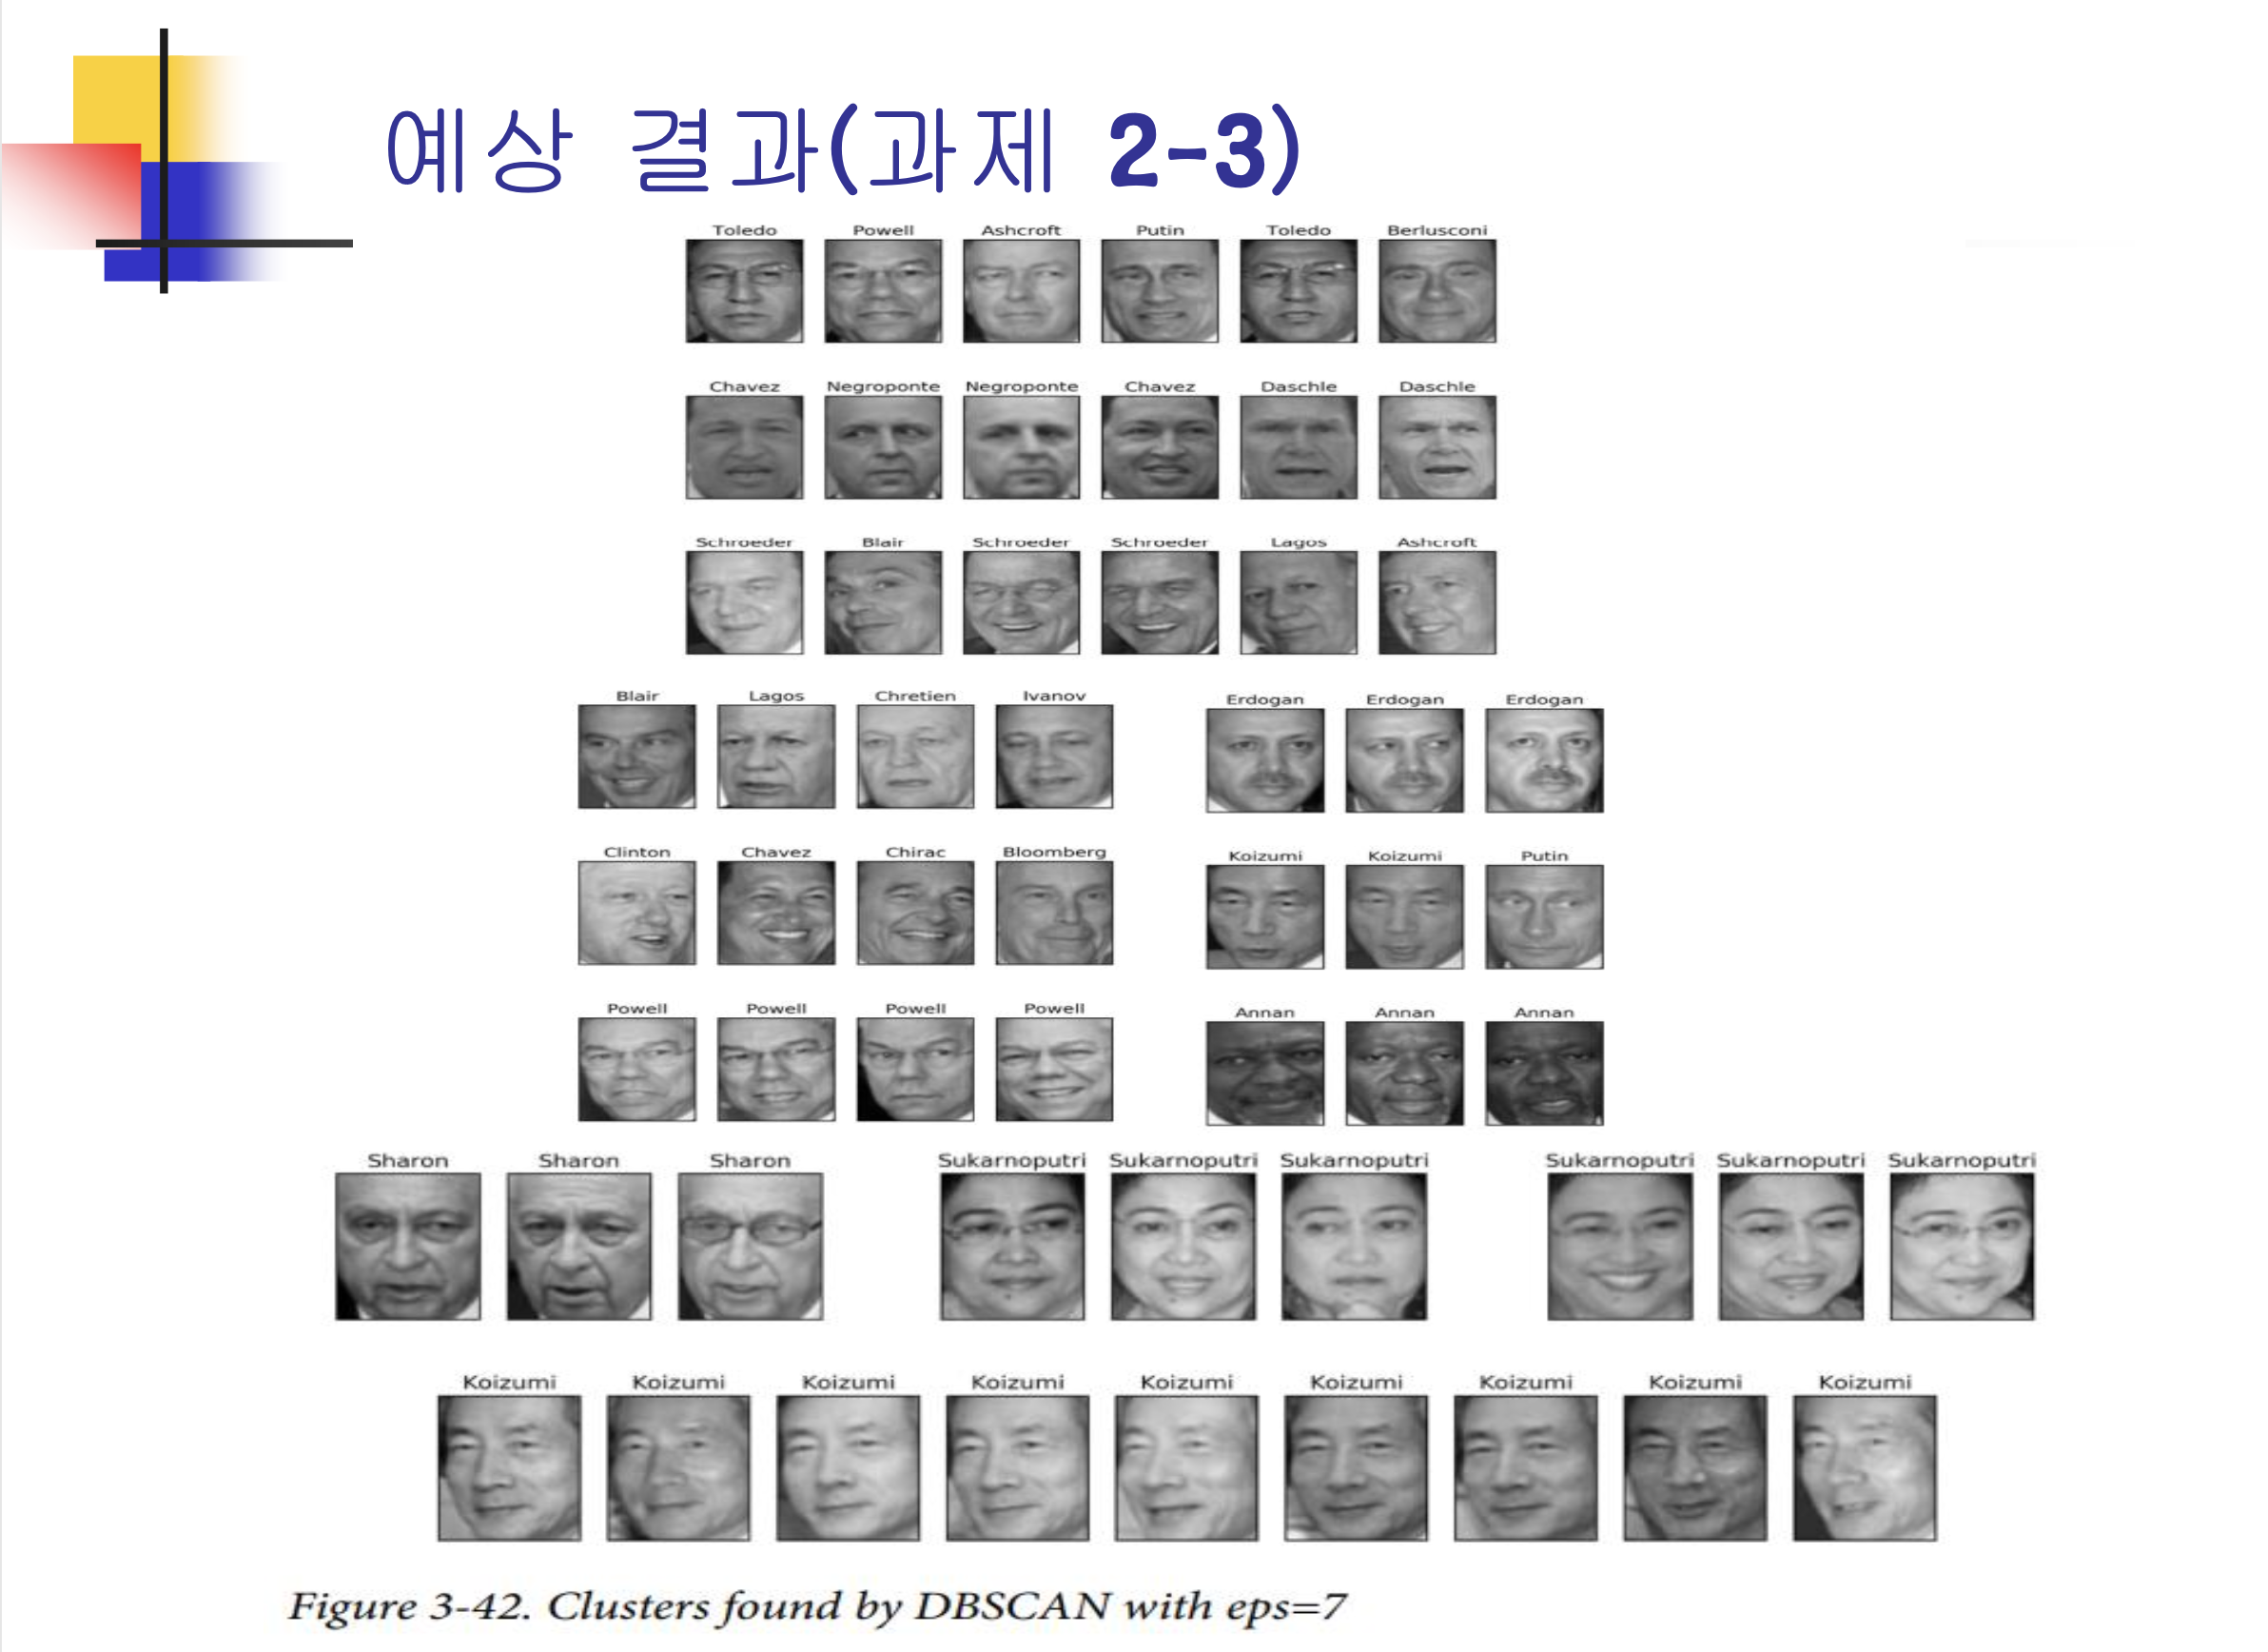

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn

In [12]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
  mask[np.where(people.target == target)[0][:50]] = 1
x_people = people.data[mask]
y_people = people.target[mask]

x_people = x_people/255

In [13]:
# eigenfaces 추출하기
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(x_people)
X_pca = pca.transform(x_people)

In [14]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print("Uinque labels: {}".format(np.unique(labels)))

Uinque labels: [-1]


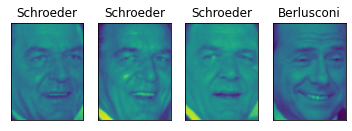

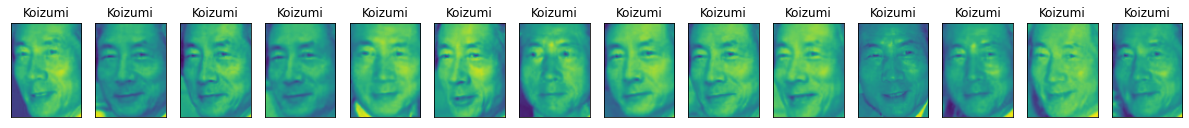

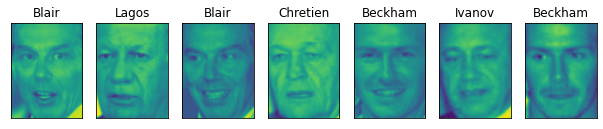

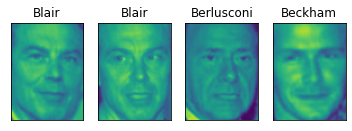

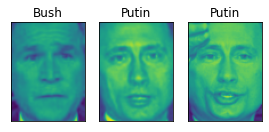

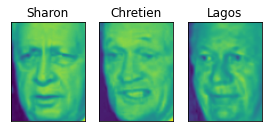

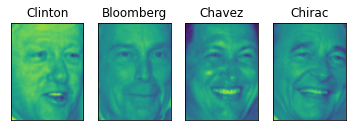

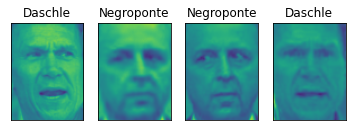

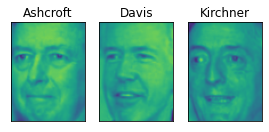

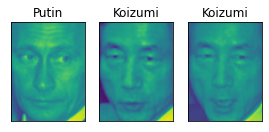

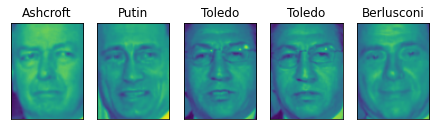

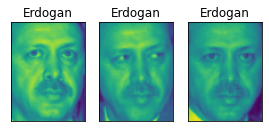

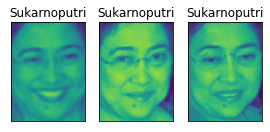

In [15]:
# dbscan 클러스터링 결과 확인하기

dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)

for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4),
                            subplot_kw={'xticks':(), 'yticks':()})
    for image, label, ax in zip(x_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])
plt.gray()
plt.show()

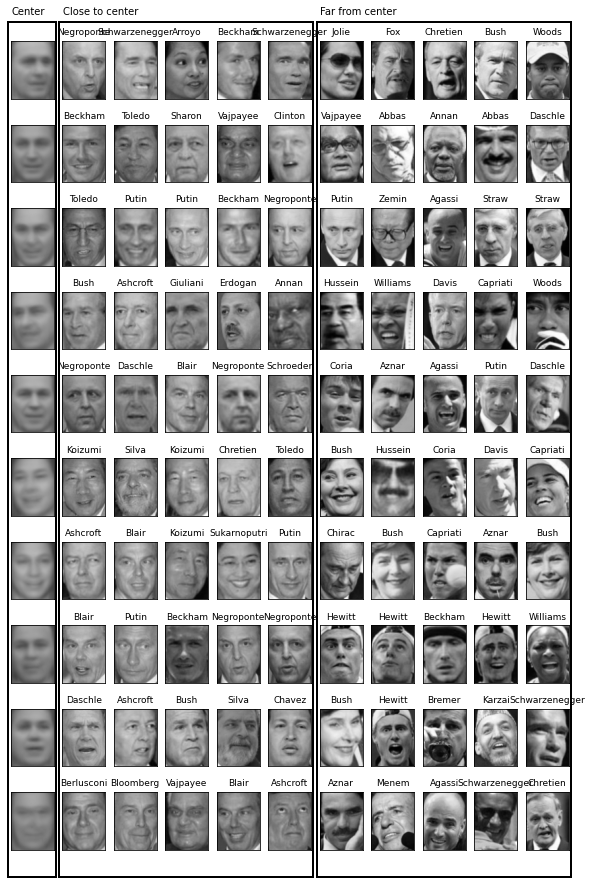

In [16]:
# k-means 결과 확인하긴

from sklearn.cluster import KMeans
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(X_pca)
mglearn.plots.plot_kmeans_faces(km, pca, X_pca, x_people, y_people, people.target_names)
plt.gray()
plt.show()

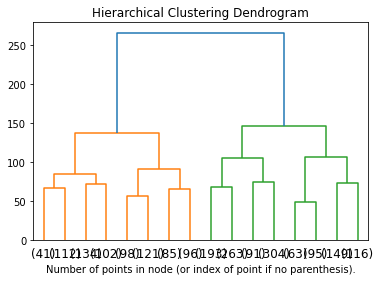

In [17]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(x_people)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()